In [21]:
import numpy as np
import pandas as pd
# import seaborn as sn
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
#import xgboost as xgb
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

In [4]:
# Join citibike data and weather data based on date
weather_data = pd.read_csv('./Data/Weather/cleaned_weather.csv')
citi_data = pd.read_csv('./Data/Citi_Bike/reduced_data.csv')

weather_data['Date'] = pd.to_datetime(weather_data['Date']).dt.date
citi_data['Date'] = pd.to_datetime(citi_data['started_at']).dt.date
data = citi_data.merge(weather_data, on='Date', how='left').dropna()
data['Date'] = pd.to_datetime(data['Date'])

data.head()

,Unnamed: 0,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,Date,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN
0,0,E12103A91226099A,docked_bike,2021-05-06 17:25:01,2021-05-06 17:45:25,Broadway & W 60 St,1 Ave & E 78 St,member,2021-05-06,9.78750,0.292644,0.0,0.0,58.333333,63.538462,48.384615
1,1,26A3DC47FE0EA3A3,docked_bike,2021-05-13 12:48:08,2021-05-13 13:07:37,Broadway & W 25 St,E 2 St & Avenue B,member,2021-05-13,6.23625,0.000000,0.0,0.0,61.333333,69.076923,45.769231
2,2,A99F2E1D627B088F,docked_bike,2021-05-16 08:30:13,2021-05-16 08:45:47,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-16,5.31250,0.000235,0.0,0.0,66.000000,75.769231,53.307692
3,3,43E79A45997B7390,docked_bike,2021-05-01 08:38:14,2021-05-01 08:54:27,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-01,13.64375,0.016375,0.0,0.0,53.333333,65.692308,41.769231
4,4,8B3CC649F4F58816,docked_bike,2021-05-09 08:12:31,2021-05-09 08:27:05,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-09,7.77125,0.301707,0.0,0.0,52.666667,59.846154,42.384615


In [4]:
data.dtypes

Unnamed: 0                     int64
ride_id                       object
rideable_type                 object
started_at                    object
ended_at                      object
start_station_name            object
end_station_name              object
member_casual                 object
Date                  datetime64[ns]
AWND                         float64
PRCP                         float64
SNOW                         float64
SNWD                         float64
TAVG                         float64
TMAX                         float64
TMIN                         float64
dtype: object

In [5]:
# split datetime into three columns: year, month, and day.
data['Date'] = pd.to_datetime(data['Date'])
data['year']=data['Date'].dt.year
data['month']=data['Date'].dt.month
data['day']=data['Date'].dt.day

In [6]:
#create season feature
data['date_offset'] = (data.Date.dt.month*100 + data.Date.dt.day - 320)%1300

data['season'] = pd.cut(data['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

In [12]:
data["year"].value_counts().values[0]
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,Date,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,year,month,day,date_offset,season
0,E12103A91226099A,docked_bike,2021-05-06 17:25:01,2021-05-06 17:45:25,Broadway & W 60 St,1 Ave & E 78 St,member,2021-05-06,9.78750,0.292644,0.0,0.0,58.333333,63.538462,48.384615,2021,5,6,186,spring
1,26A3DC47FE0EA3A3,docked_bike,2021-05-13 12:48:08,2021-05-13 13:07:37,Broadway & W 25 St,E 2 St & Avenue B,member,2021-05-13,6.23625,0.000000,0.0,0.0,61.333333,69.076923,45.769231,2021,5,13,193,spring
2,A99F2E1D627B088F,docked_bike,2021-05-16 08:30:13,2021-05-16 08:45:47,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-16,5.31250,0.000235,0.0,0.0,66.000000,75.769231,53.307692,2021,5,16,196,spring
3,43E79A45997B7390,docked_bike,2021-05-01 08:38:14,2021-05-01 08:54:27,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-01,13.64375,0.016375,0.0,0.0,53.333333,65.692308,41.769231,2021,5,1,181,spring
4,8B3CC649F4F58816,docked_bike,2021-05-09 08:12:31,2021-05-09 08:27:05,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-09,7.77125,0.301707,0.0,0.0,52.666667,59.846154,42.384615,2021,5,9,189,spring


### Missing values

In [14]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,Date,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,year,month,day,date_offset,season
0,E12103A91226099A,docked_bike,2021-05-06 17:25:01,2021-05-06 17:45:25,Broadway & W 60 St,1 Ave & E 78 St,member,2021-05-06,9.78750,0.292644,0.0,0.0,58.333333,63.538462,48.384615,2021,5,6,186,spring
1,26A3DC47FE0EA3A3,docked_bike,2021-05-13 12:48:08,2021-05-13 13:07:37,Broadway & W 25 St,E 2 St & Avenue B,member,2021-05-13,6.23625,0.000000,0.0,0.0,61.333333,69.076923,45.769231,2021,5,13,193,spring
2,A99F2E1D627B088F,docked_bike,2021-05-16 08:30:13,2021-05-16 08:45:47,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-16,5.31250,0.000235,0.0,0.0,66.000000,75.769231,53.307692,2021,5,16,196,spring
3,43E79A45997B7390,docked_bike,2021-05-01 08:38:14,2021-05-01 08:54:27,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-01,13.64375,0.016375,0.0,0.0,53.333333,65.692308,41.769231,2021,5,1,181,spring
4,8B3CC649F4F58816,docked_bike,2021-05-09 08:12:31,2021-05-09 08:27:05,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-09,7.77125,0.301707,0.0,0.0,52.666667,59.846154,42.384615,2021,5,9,189,spring


In [15]:
missing_number = data.isnull().sum().sort_values(ascending=False)
missing_percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['missNum', 'missPercent'])

print(missing_values)


                    missNum  missPercent
season               138135     0.002174
rideable_type             0     0.000000
date_offset               0     0.000000
day                       0     0.000000
month                     0     0.000000
year                      0     0.000000
TMIN                      0     0.000000
TMAX                      0     0.000000
TAVG                      0     0.000000
SNWD                      0     0.000000
ride_id                   0     0.000000
PRCP                      0     0.000000
AWND                      0     0.000000
Date                      0     0.000000
member_casual             0     0.000000
end_station_name          0     0.000000
start_station_name        0     0.000000
ended_at                  0     0.000000
started_at                0     0.000000
SNOW                      0     0.000000


### Outliers

In [16]:
data.describe()

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,year,month,day,date_offset
count,6.354454e+07,6.354454e+07,6.354454e+07,6.354454e+07,6.354454e+07,6.354454e+07,6.354454e+07,6.354454e+07,6.354454e+07,6.354454e+07,6.354454e+07
mean,7.633662e+00,1.278388e-01,1.024231e-02,2.775511e-02,6.197669e+01,6.921336e+01,5.172336e+01,2.021754e+03,6.774256e+00,1.570577e+01,5.424121e+02
std,2.727793e+00,3.639875e-01,1.379844e-01,2.903304e-01,1.480935e+01,1.533693e+01,1.459770e+01,6.763311e-01,3.025535e+00,8.656179e+00,3.442080e+02
min,2.292500e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.100000e+01,2.292308e+01,3.428571e+00,2.021000e+03,1.000000e+00,1.000000e+00,0.000000e+00
25%,5.648750e+00,2.380952e-04,0.000000e+00,0.000000e+00,5.100000e+01,5.766667e+01,4.000000e+01,2.021000e+03,4.000000e+00,8.000000e+00,2.870000e+02
50%,7.046250e+00,9.662921e-03,0.000000e+00,0.000000e+00,6.433333e+01,7.150000e+01,5.323077e+01,2.022000e+03,7.000000e+00,1.600000e+01,4.990000e+02
75%,9.142500e+00,9.890110e-02,0.000000e+00,0.000000e+00,7.500000e+01,8.176923e+01,6.407692e+01,2.022000e+03,9.000000e+00,2.300000e+01,7.820000e+02
max,2.004875e+01,5.291300e+00,5.624528e+00,7.607500e+00,8.800000e+01,9.653846e+01,7.761538e+01,2.023000e+03,1.200000e+01,3.100000e+01,1.299000e+03


### Correlation Heatmap

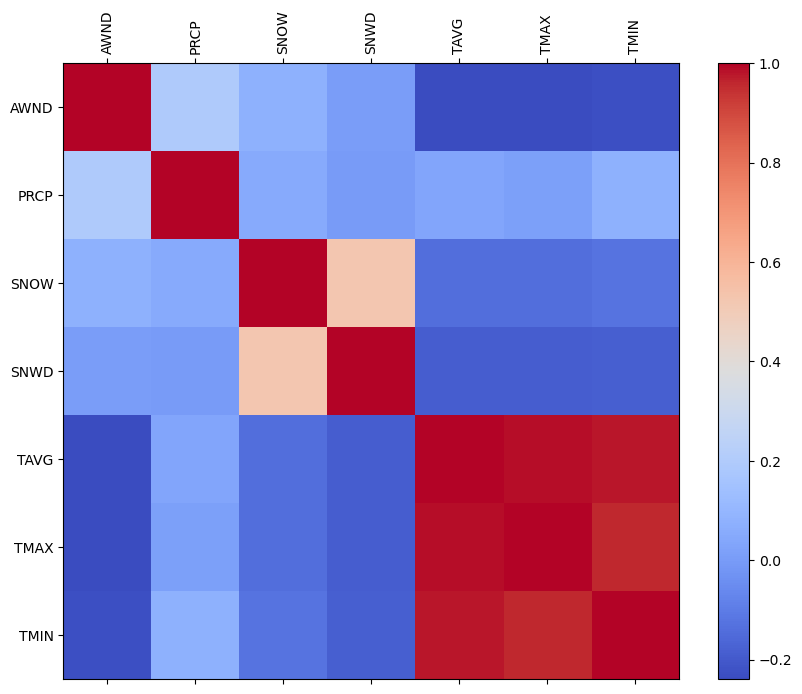

In [23]:
# def correlation_heatmap(corr):
#     mask = np.array(corr)
#     mask[np.tril_indices_from(mask)] = False
#     fig,ax= plt.subplots()
#     fig.set_size_inches(20,10)
#     sn.heatmap(corr, annot=True, mask=mask)

def correlation_heatmap(corr):
    mask = np.tril(corr)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    cax = ax.matshow(corr, cmap='coolwarm')
    fig.colorbar(cax)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.show()

corr = data[['AWND', 'PRCP','SNOW', 'SNWD','TAVG', 'TMAX','TMIN', 'season']].corr()
correlation_heatmap(corr)

After analyzing the dataset, we found that all features except for three temperature-related features, namely 'max_temperature', 'min_temperature', and 'average_temperature', appear to be fine. However, these temperature features exhibit a high degree of correlation among themselves. To address this issue, we have decided to drop two of the temperature features.

High correlation between these temperature features suggests that they provide similar information, leading to redundancy in our data. By removing two of the highly correlated features, we aim to reduce multicollinearity and potential overfitting in our model.

To make the decision on which features to drop, we calculated the correlation matrix for the temperature features. The correlation coefficient between 'max_temperature' and 'min_temperature' was found to be above our predefined threshold of 0.9. Consequently, we decided to drop one of these features based on our domain knowledge or specific modeling requirements.

In [28]:
# Decide which feature(s) to drop
corr_matrix = data[['TMAX', 'TMIN', 'TAVG']].corr()
threshold = 0.9  

if corr_matrix.loc['TMAX', 'TMIN'] >= threshold:
    # 'max_temperature' and 'min_temperature' are highly correlated
    data.drop('TMIN', axis=1, inplace=True)
elif corr_matrix.loc['TMAX', 'TAVG'] >= threshold:
    # 'max_temperature' and 'average_temperature' are highly correlated
    data.drop('TAVG', axis=1, inplace=True)


In [29]:
data.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,Date,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,year,month,day,date_offset,season
0,E12103A91226099A,docked_bike,2021-05-06 17:25:01,2021-05-06 17:45:25,Broadway & W 60 St,1 Ave & E 78 St,member,2021-05-06,9.78750,0.292644,0.0,0.0,58.333333,63.538462,2021,5,6,186,spring
1,26A3DC47FE0EA3A3,docked_bike,2021-05-13 12:48:08,2021-05-13 13:07:37,Broadway & W 25 St,E 2 St & Avenue B,member,2021-05-13,6.23625,0.000000,0.0,0.0,61.333333,69.076923,2021,5,13,193,spring
2,A99F2E1D627B088F,docked_bike,2021-05-16 08:30:13,2021-05-16 08:45:47,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-16,5.31250,0.000235,0.0,0.0,66.000000,75.769231,2021,5,16,196,spring
3,43E79A45997B7390,docked_bike,2021-05-01 08:38:14,2021-05-01 08:54:27,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-01,13.64375,0.016375,0.0,0.0,53.333333,65.692308,2021,5,1,181,spring
4,8B3CC649F4F58816,docked_bike,2021-05-09 08:12:31,2021-05-09 08:27:05,46 Ave & 5 St,34th Ave & Vernon Blvd,member,2021-05-09,7.77125,0.301707,0.0,0.0,52.666667,59.846154,2021,5,9,189,spring
